# Unsupervised Learning: AllLife Bank Customer Segmenation

## Problem Statement

### Context

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. The Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customers, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

### Data Dictionary

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online, and through a call center).
r- `Sl_No`: Primary key of the records
- `Customer Key`: Customer identification number
- `Average Credit Limit`: Average credit limit of each customer for all credit cards
- `Total credit cards`: Total number of credit cards possessed by the customer
- `Total visits bank`: Total number of visits that customer made (yearly) personally to the bank
- `Total visits online`: Total number of visits or online logins made by the customer (yearly)
- `Total calls made`: Total number of calls made by the customer to the bank or its customer service department (yearly) (yearly)

## Importing necessary libraries

In [43]:
# Installing the libraries with the specified version.
#!pip install scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.2 yellowbrick==1.5 -q --user
#!pip install --upgrade -q jinja2
!pip install -U yellowbrick

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [45]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid')

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

## Loading the dataset

In [47]:
import os
path = os.getcwd() + '\\Credit Card Customer Data.xlsx'
data = pd.read_excel(path)

## Overview of the Dataset

### Checking the shape of the dataset

In [50]:
# checking shape of the data
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns in the dataset") ## Complete the code to get the shape of data

There are 660 rows and 7 columns in the dataset


### Displaying few rows of the dataset

In [52]:
# let's view a sample of the data
data.sample(n=10, random_state=1)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
547,548,38125,26000,4,5,2,4
353,354,94437,9000,5,4,1,3
499,500,65825,68000,6,4,2,2
173,174,38410,9000,2,1,5,8
241,242,81878,10000,4,5,1,3
341,342,70779,18000,4,3,2,0
647,648,79953,183000,9,0,9,2
218,219,28208,19000,3,1,5,7
120,121,16577,10000,4,2,4,6
134,135,31256,13000,4,1,5,7


### Checking the data types of the columns for the dataset

In [54]:
# checking the column names and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


### Creating a copy of original data

In [56]:
# copying the data to another variable to avoid any changes to original data
df_temp = data.copy()

### Checking for duplicates and missing values

In [58]:
# checking for duplicate values
print('Duplicated Values:-')
df_temp.duplicated().sum()

Duplicated Values:-


0

In [59]:
# checking for missing values in the data
print('Missing Values:-')
df_temp.isnull().sum()

Missing Values:-


Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Checking Keys

In [61]:
# Sl_No is the key of the table. Lets check whether it is unique for each row
# Also, Customer Key is the unique identifier for each customer in the table. Lets check if it is unique or duplicated
print('No. of Rows in the dataset = ',df_temp.shape[0])
print('Unique values for | Sl_No = ',df_temp['Sl_No'].nunique())
print('Unique values for | Customer Key = ',df_temp['Customer Key'].nunique())

No. of Rows in the dataset =  660
Unique values for | Sl_No =  660
Unique values for | Customer Key =  655


In [62]:
#Analyze Duplicated Customer Keys

df_temp[df_temp['Customer Key'].isin(df_temp[df_temp['Customer Key'].duplicated()]['Customer Key'].tolist())].sort_values('Customer Key')

# All duplicated values seem to represent a different customer. So, these duplicated customer key entries may be wrongly entered.
# As of now, we shall consider these as separate customers

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


In [63]:
# Both keys serve no purpose in the analysis ahead as they are unique identifiers, so we shall drop them & create a new dataset
df = df_temp.copy()
df.drop(columns=['Customer Key', 'Sl_No'], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Avg_Credit_Limit     660 non-null    int64
 1   Total_Credit_Cards   660 non-null    int64
 2   Total_visits_bank    660 non-null    int64
 3   Total_visits_online  660 non-null    int64
 4   Total_calls_made     660 non-null    int64
dtypes: int64(5)
memory usage: 25.9 KB


### Statistical summary of the dataset

**Let's check the statistical summary of the data.**

In [66]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


## Exploratory Data Analysis

### Univariate analysis

In [69]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(df, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=df, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=df, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        df[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        df[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [70]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [71]:
#Create a copy of dataset in case there is a need to bin features during EDA
df_eda = df.copy()

#create a new column to bin Avg_Credit_Limit
df_eda['Avg_Credit_Limit_Bins'] = pd.cut(df_eda['Avg_Credit_Limit'], bins=[3000, 10000, 50000, 200000]
                                ,labels=['Low', 'Mid', 'High'], include_lowest=True)

**`Avg_Credit_Limit_Bins`**

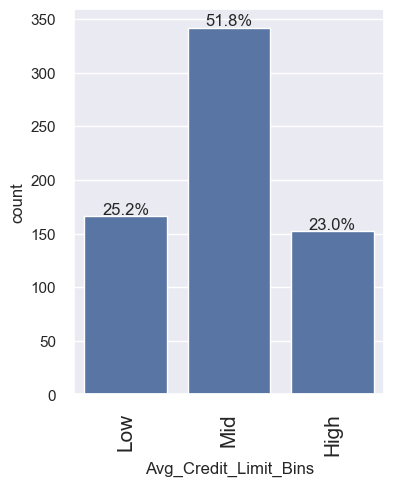

In [73]:
labeled_barplot(df_eda, 'Avg_Credit_Limit_Bins', perc=True)

**`Avg_Credit_Limit`**

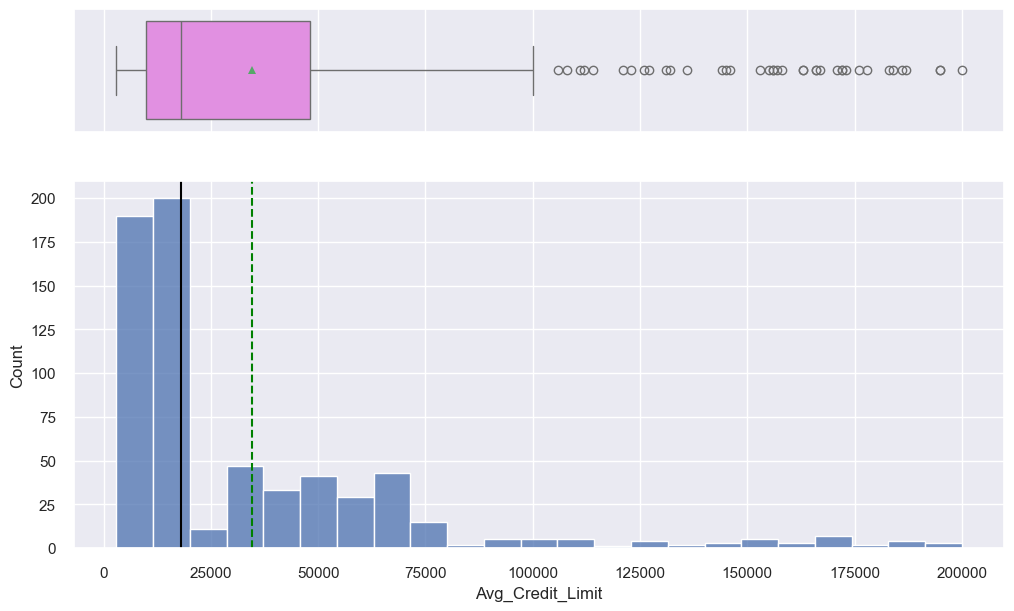

In [75]:
histogram_boxplot(df_eda, 'Avg_Credit_Limit')

**`Total_Credit_Cards`**

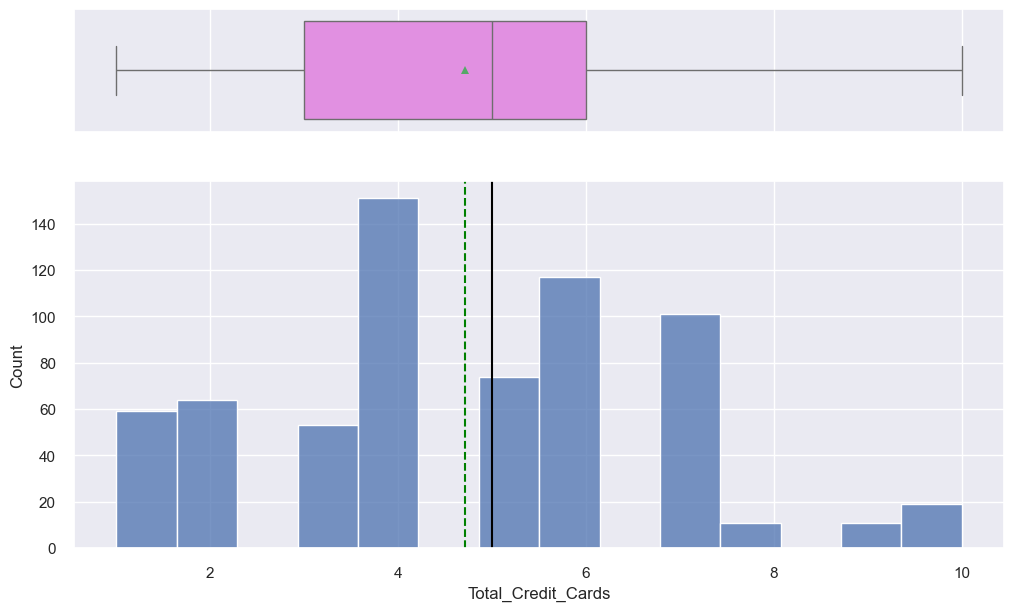

In [77]:
histogram_boxplot(df_eda, 'Total_Credit_Cards')

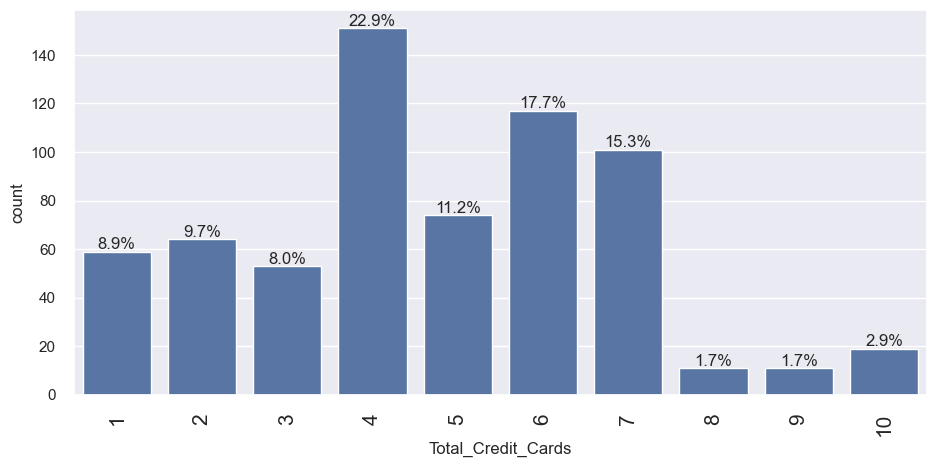

In [78]:
labeled_barplot(df_eda, 'Total_Credit_Cards', perc=True)

**`Total_visits_bank`**

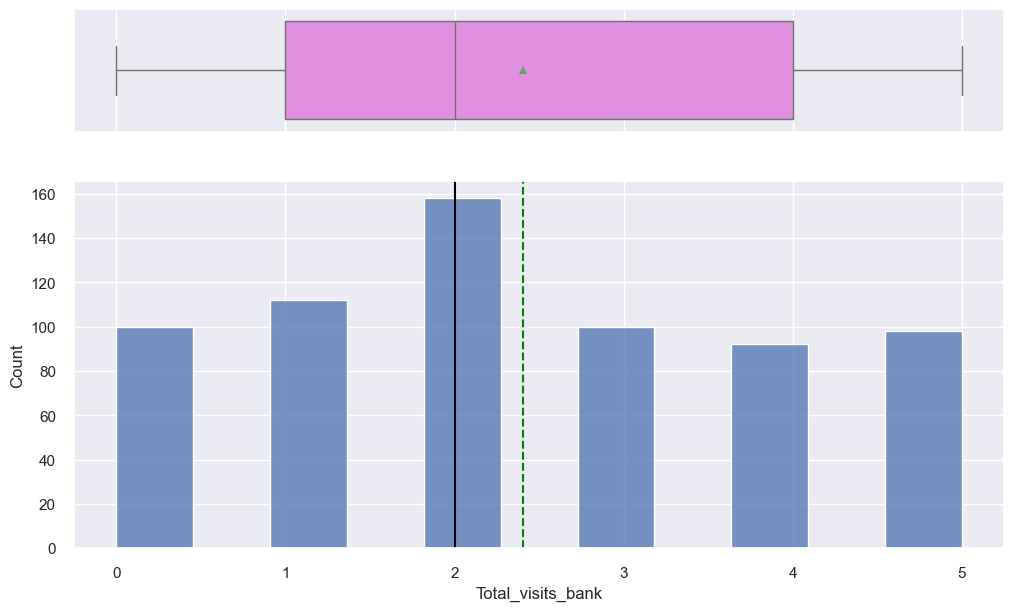

In [80]:
histogram_boxplot(df_eda, 'Total_visits_bank')

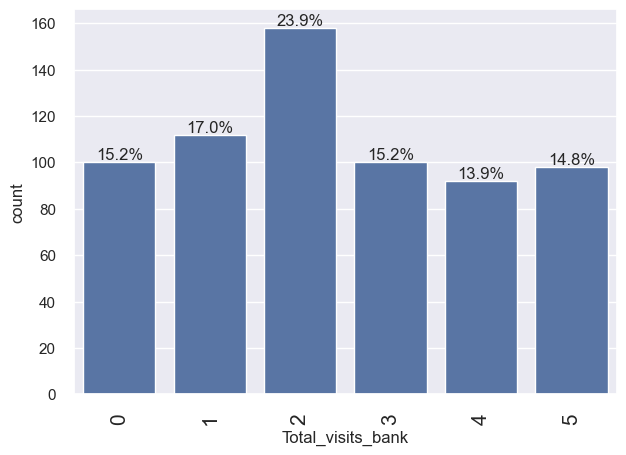

In [81]:
labeled_barplot(df_eda, 'Total_visits_bank', perc=True)

**`Total_visits_online`**

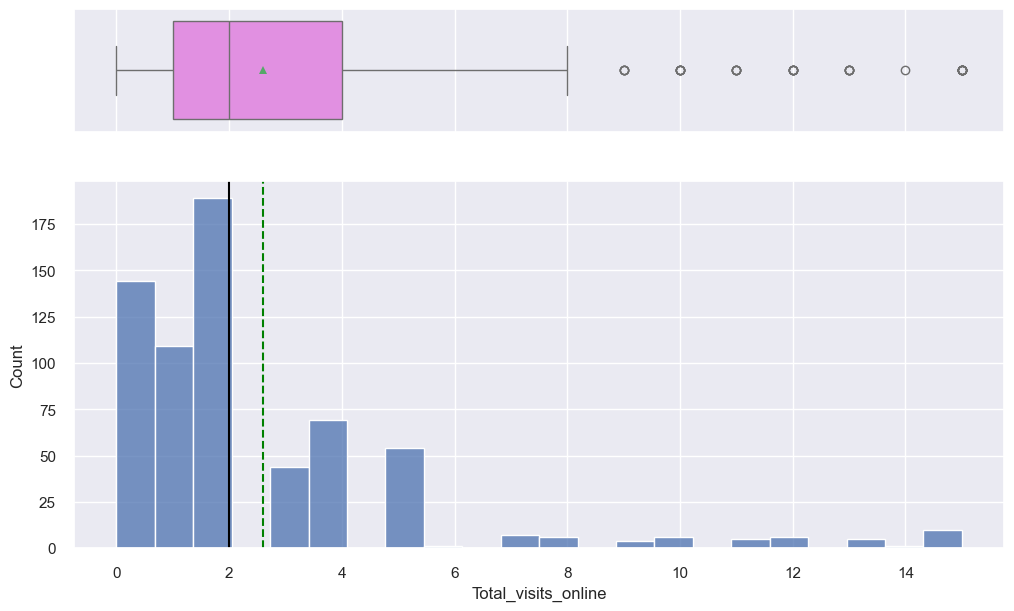

In [83]:
histogram_boxplot(df_eda, 'Total_visits_online')

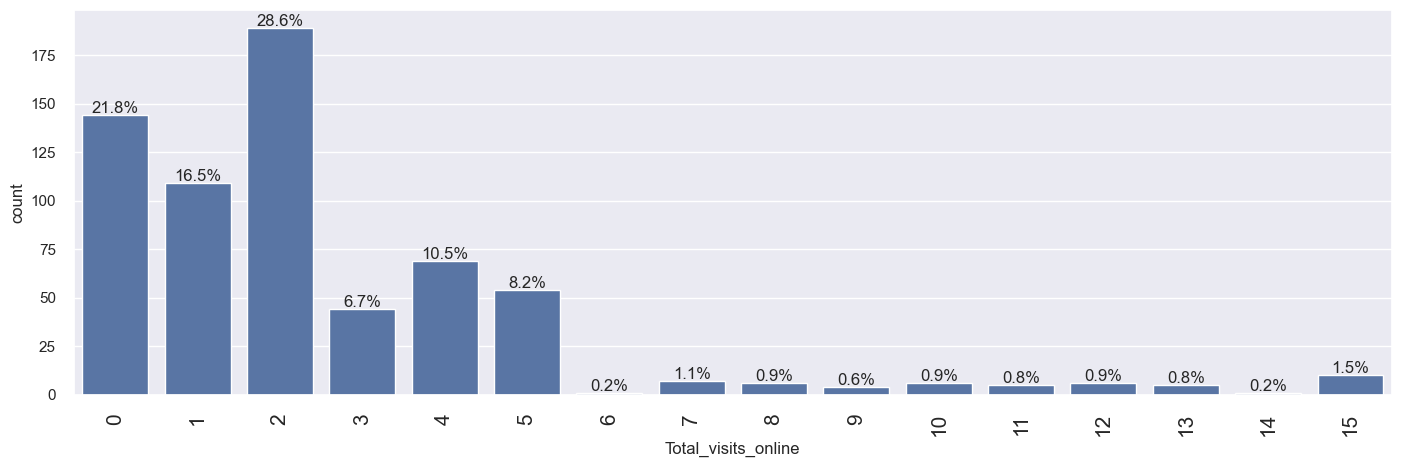

In [84]:
labeled_barplot(df_eda, 'Total_visits_online', perc=True)

**`Total_calls_made`**

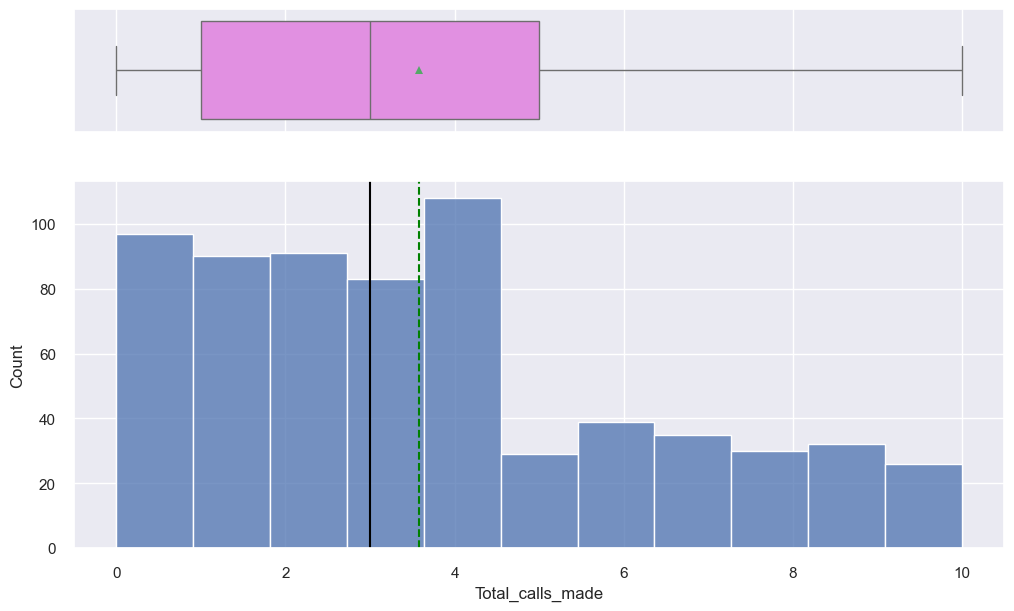

In [86]:
histogram_boxplot(df_eda, 'Total_calls_made')

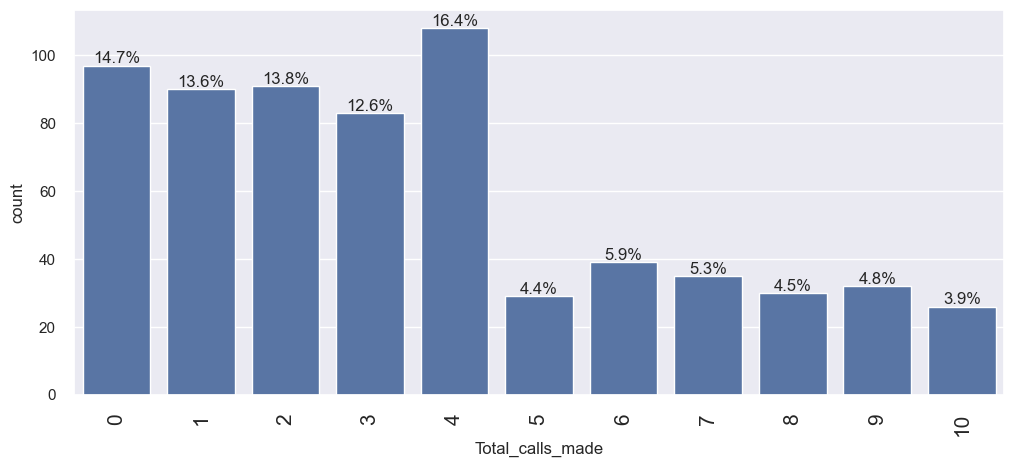

In [87]:
labeled_barplot(df_eda, 'Total_calls_made', perc=True)

### Bivariate Analysis

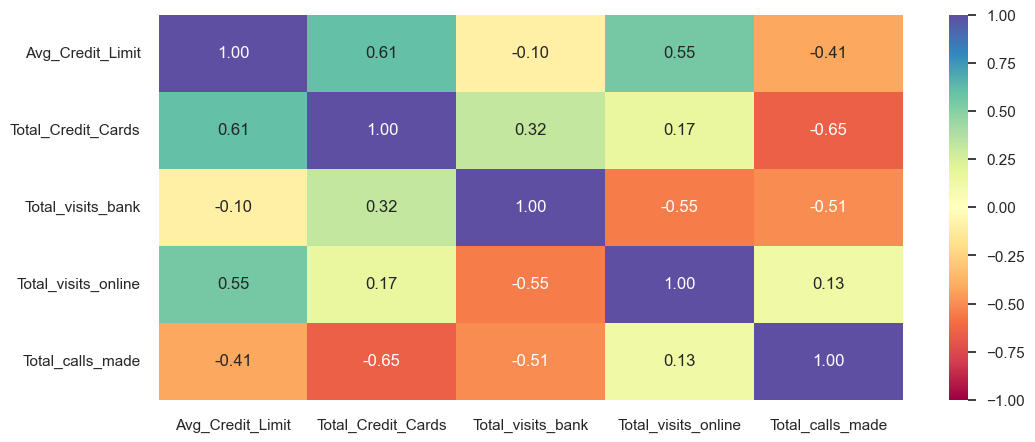

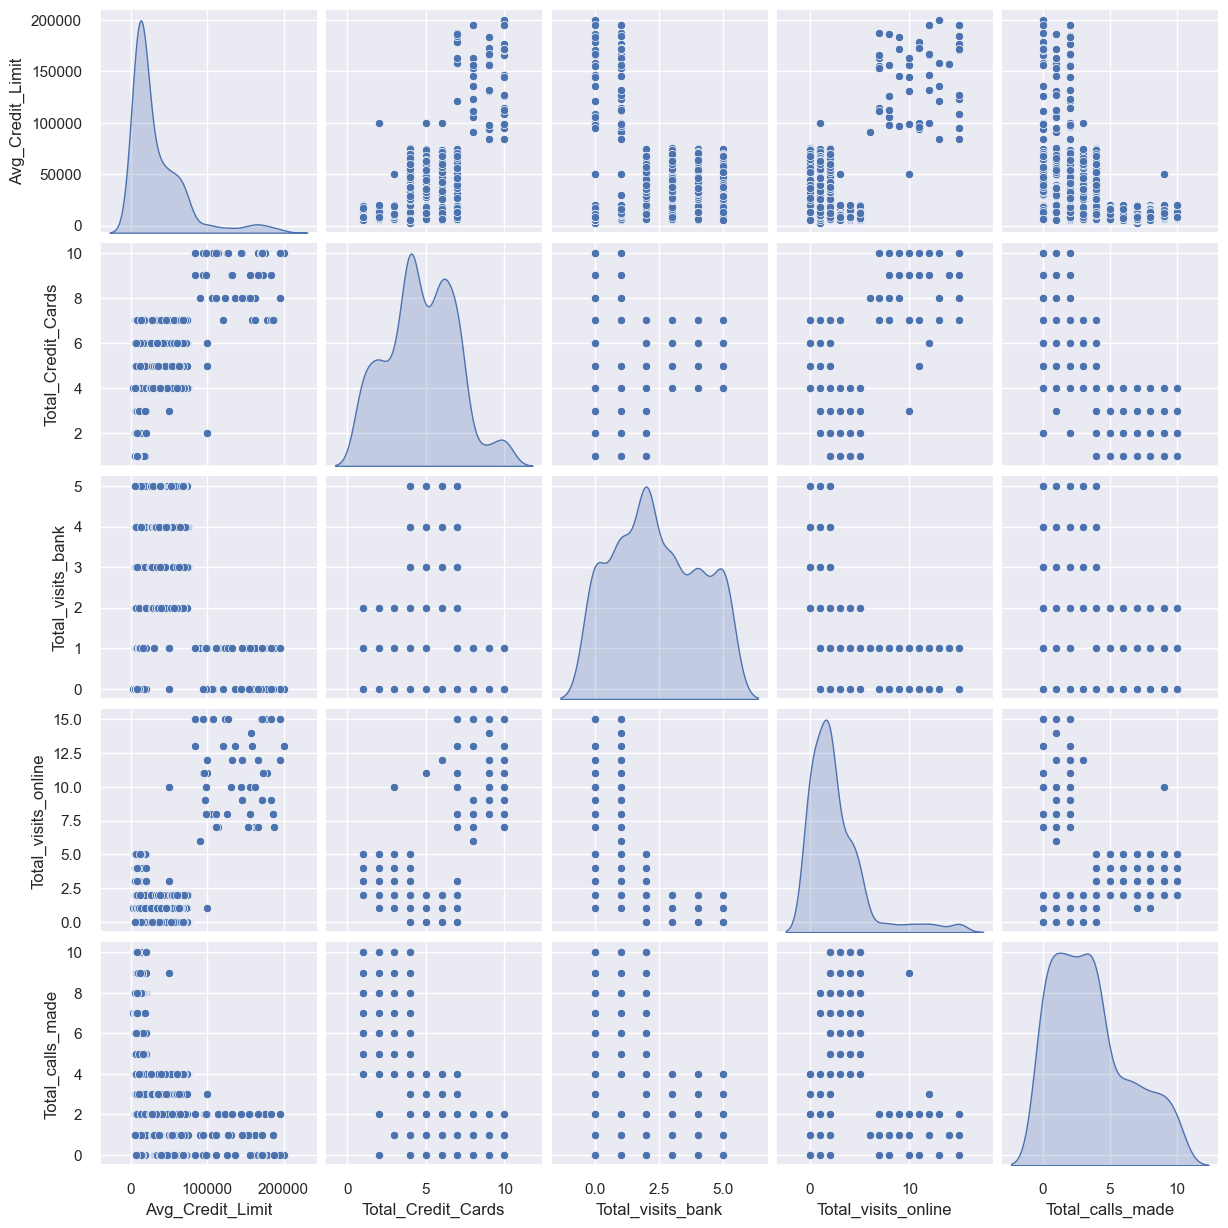

In [89]:
# correlation check
plt.figure(figsize=(12, 5))
sns.heatmap(
    df.corr(numeric_only = True), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

sns.pairplot(df, diag_kind = 'kde')

**Average Credit Limit distribution by Each of the Other Attributes**

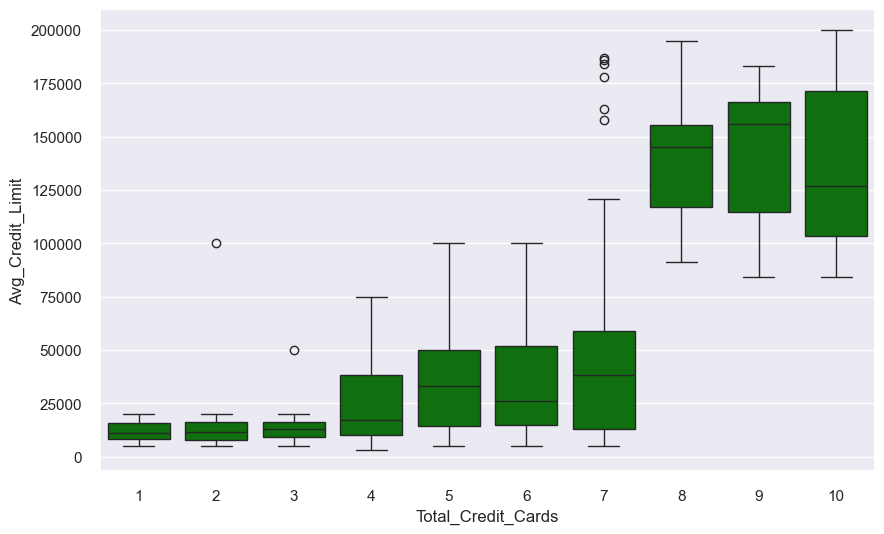

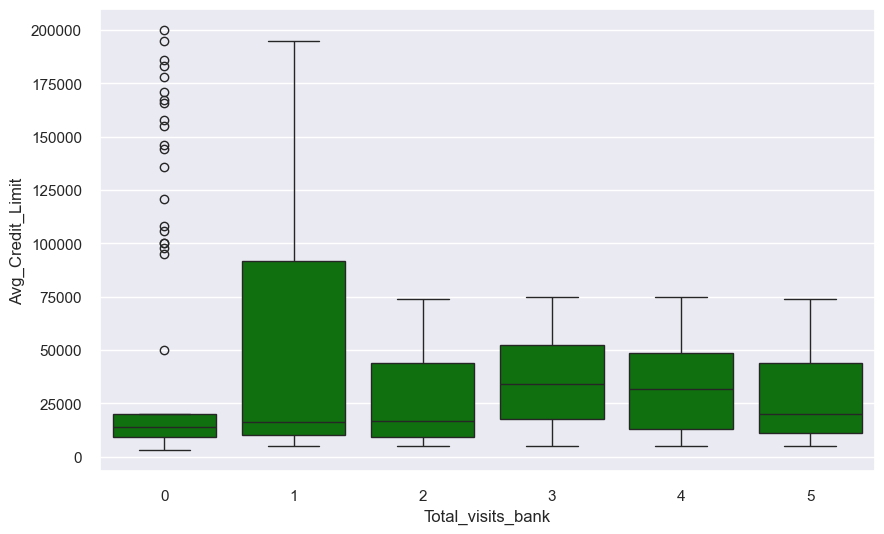

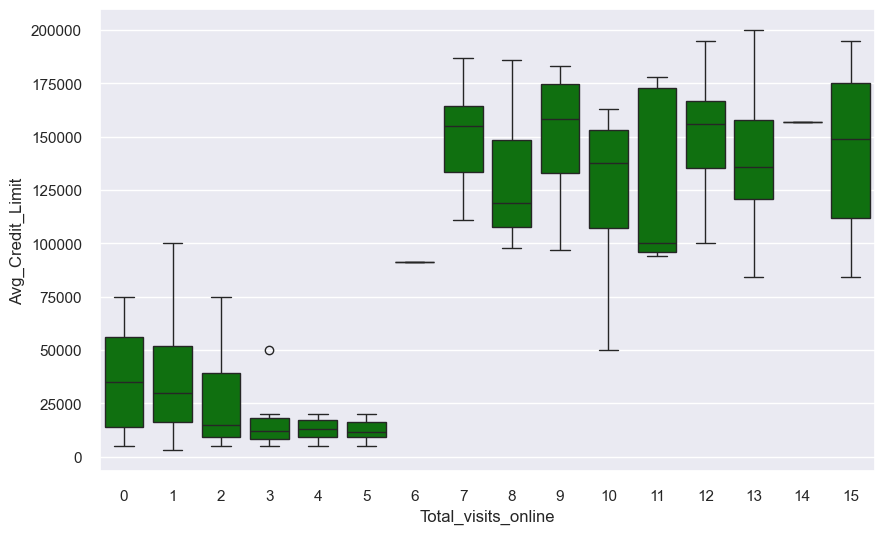

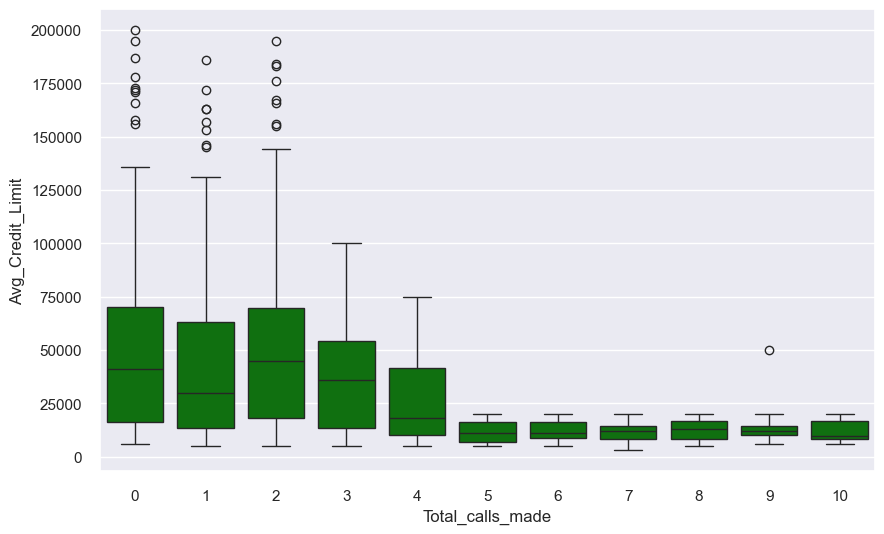

In [91]:
col = ['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
for i in col:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df, x=df[i], y='Avg_Credit_Limit', color='green')
    plt.show()

## Data Preprocessing

### Outlier Check

- Let's plot the boxplots of all numerical columns to check for outliers.

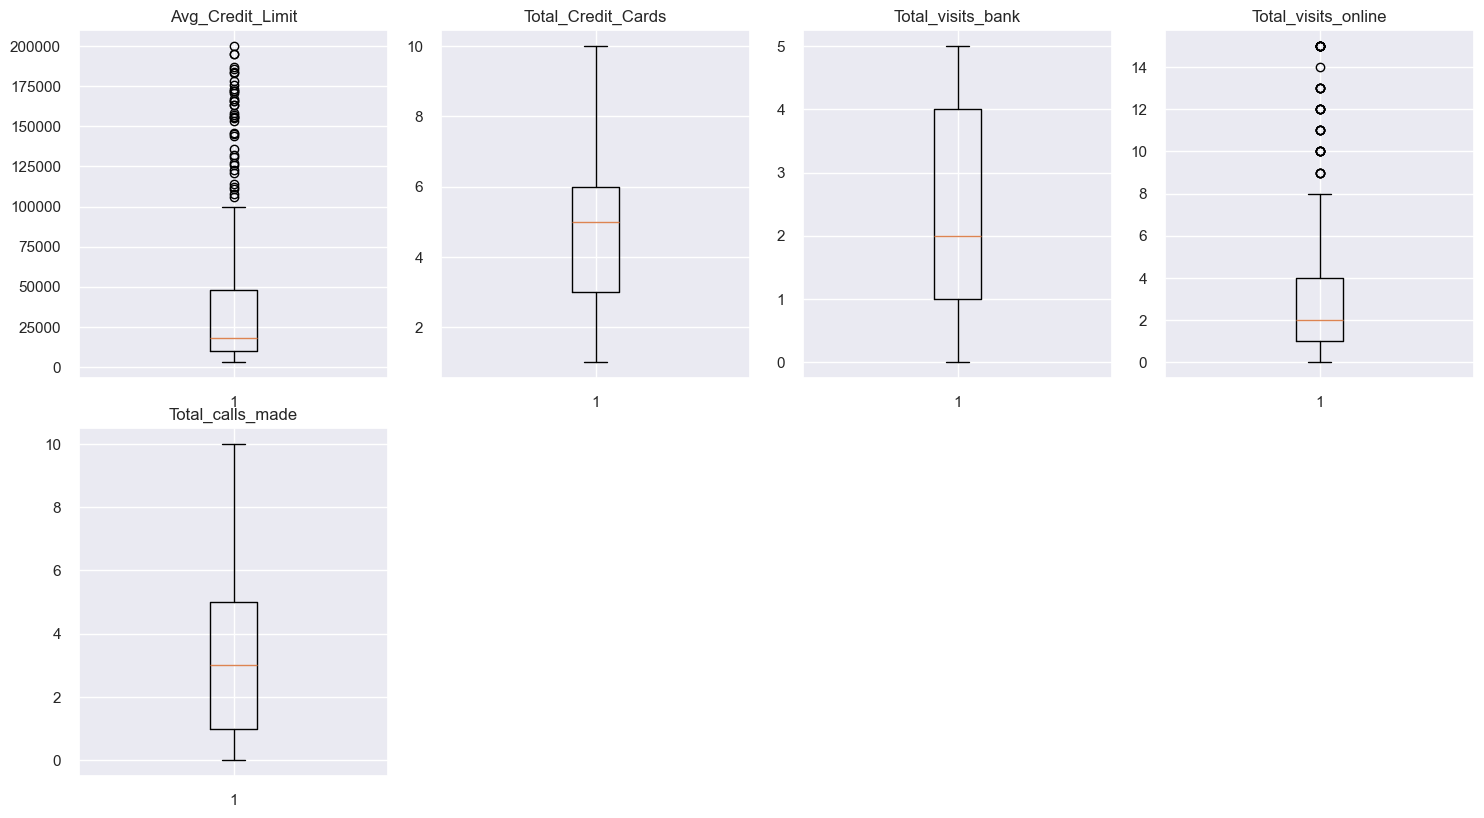

In [94]:
plt.figure(figsize=(15, 12))

numeric_columns = df.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(numeric_columns):
    plt.subplot(3, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

In [95]:
# Define function to get Upper & Lower Whiskers of boxplot
def Whiskers(c):
    sorted(c)
    Q1,Q3 = np.percentile(c,[25,75])
    LW = Q1 - (Q3-Q1)*1.5
    UW = Q3 + (Q3-Q1)*1.5
    return LW,UW


# Avg_Credit_Limit: Calculate Outlier Count & Percentage
print('************************************************ Outlier Analysis - Avg_Credit_Limit ************************************************')
L_Whis,U_Whis = Whiskers(df['Avg_Credit_Limit'])
UW_count = df[df['Avg_Credit_Limit']>U_Whis].shape[0]
LW_count = df[df['Avg_Credit_Limit']<L_Whis].shape[0]
Outlier_count = LW_count + UW_count
Col_count = df['Avg_Credit_Limit'].shape[0]
Outlier_Percentage = round((Outlier_count/Col_count)*100,2)
print('Lower Wishker at',L_Whis,'| Upper Whisker at',U_Whis)
print('Lower Whisker Outlier Count =',LW_count)
print('Upper Whisker Outlier Count =',UW_count)
print('Total Outlier Count=',Outlier_count)
print('Outlier Percentage in Avg_Credit_Limit=',Outlier_Percentage,'%')

# Total_visits_online: Calculate Outlier Count & Percentage
print('************************************************ Outlier Analysis - Total_visits_online ************************************************')
L_Whis,U_Whis = Whiskers(df['Total_visits_online'])
UW_count = df[df['Total_visits_online']>U_Whis].shape[0]
LW_count = df[df['Total_visits_online']<L_Whis].shape[0]
Outlier_count = LW_count + UW_count
Col_count = df['Total_visits_online'].shape[0]
Outlier_Percentage = round((Outlier_count/Col_count)*100,2)
print('Lower Wishker at',L_Whis,'| Upper Whisker at',U_Whis)
print('Lower Whisker Outlier Count =',LW_count)
print('Upper Whisker Outlier Count =',UW_count)
print('Total Outlier Count=',Outlier_count)
print('Outlier Percentage in Total_visits_online=',Outlier_Percentage,'%')

# Even though the Outlier count is high, we choose not to treat the outliers to avoid any loss if information

************************************************ Outlier Analysis - Avg_Credit_Limit ************************************************
Lower Wishker at -47000.0 | Upper Whisker at 105000.0
Lower Whisker Outlier Count = 0
Upper Whisker Outlier Count = 39
Total Outlier Count= 39
Outlier Percentage in Avg_Credit_Limit= 5.91 %
************************************************ Outlier Analysis - Total_visits_online ************************************************
Lower Wishker at -3.5 | Upper Whisker at 8.5
Lower Whisker Outlier Count = 0
Upper Whisker Outlier Count = 37
Total Outlier Count= 37
Outlier Percentage in Total_visits_online= 5.61 %


### Scaling

- Let's scale the data before we proceed with clustering.

In [97]:
df_z = df.apply(zscore)
df_z.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


## K-means Clustering

### Checking Elbow Plot

In [100]:
k_means_df = df_z.copy()

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.7178787250175893
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0902973540817664
Number of Clusters: 5 	Average Distortion: 0.9906853650098948
Number of Clusters: 6 	Average Distortion: 0.9515009282361341
Number of Clusters: 7 	Average Distortion: 0.9094119827472316
Number of Clusters: 8 	Average Distortion: 0.9191292344244387
Number of Clusters: 9 	Average Distortion: 0.8990131857179275
Number of Clusters: 10 	Average Distortion: 0.8723089051392604
Number of Clusters: 11 	Average Distortion: 0.8353621156593081
Number of Clusters: 12 	Average Distortion: 0.80956116944126
Number of Clusters: 13 	Average Distortion: 0.7950761910849837
Number of Clusters: 14 	Average Distortion: 0.7740825528304729


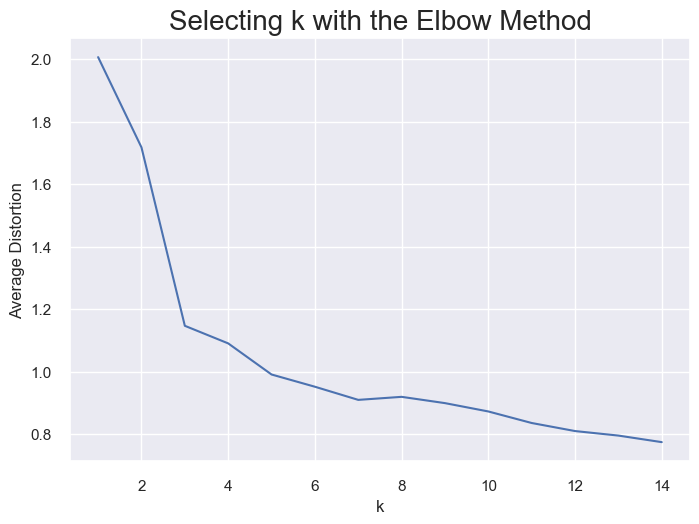

In [101]:
clusters = range(1, 15)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(k_means_df)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1))
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.show()

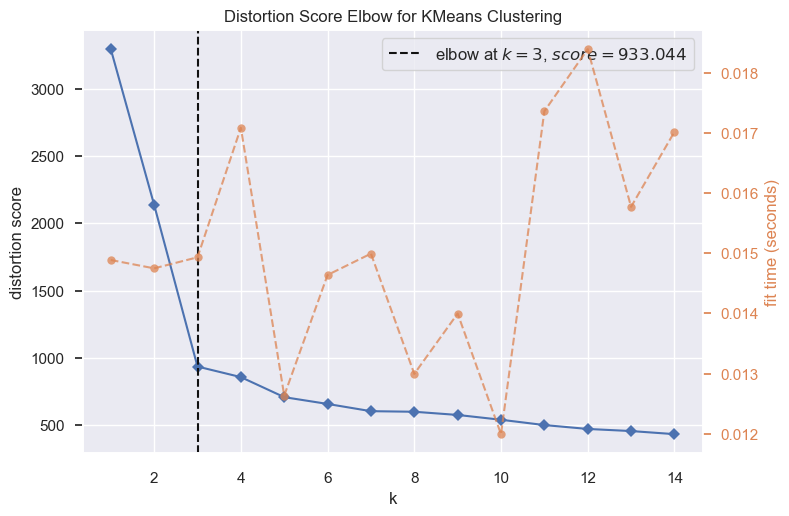

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [102]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(1, 15), timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

### Let's check the silhouette scores

For n_clusters = 2, the silhouette score is 0.5703183487340514)
For n_clusters = 3, the silhouette score is 0.5157182558881063)
For n_clusters = 4, the silhouette score is 0.3744071798973986)
For n_clusters = 5, the silhouette score is 0.27167502160723267)
For n_clusters = 6, the silhouette score is 0.24804756291576194)
For n_clusters = 7, the silhouette score is 0.24791254258020035)
For n_clusters = 8, the silhouette score is 0.22570382558070443)
For n_clusters = 9, the silhouette score is 0.19931783829027247)
For n_clusters = 10, the silhouette score is 0.20939001908412339)
For n_clusters = 11, the silhouette score is 0.21874494421167007)
For n_clusters = 12, the silhouette score is 0.21076471529358776)
For n_clusters = 13, the silhouette score is 0.2110262471212854)
For n_clusters = 14, the silhouette score is 0.21513441980318038)


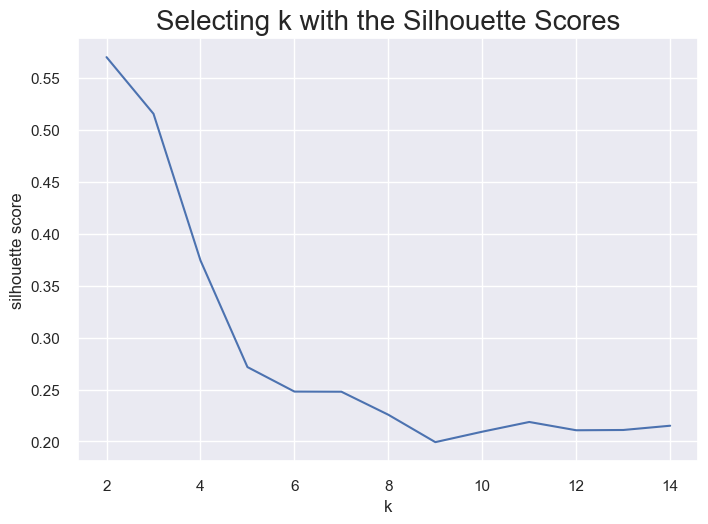

In [104]:
sil_score = []
cluster_list = range(2, 15)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((k_means_df))
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.title("Selecting k with the Silhouette Scores", fontsize=20)
plt.show()

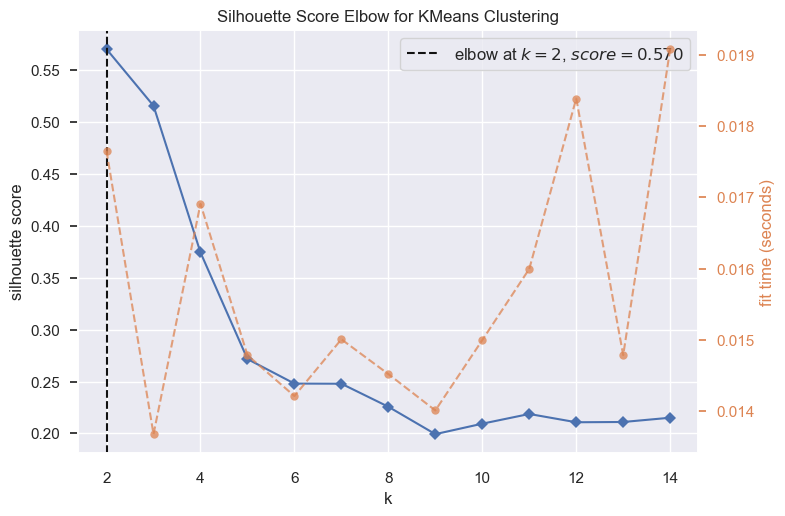

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [105]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=True)
visualizer.fit(k_means_df)  # fit the data to the visualizer
visualizer.show()  # finalize and render figure

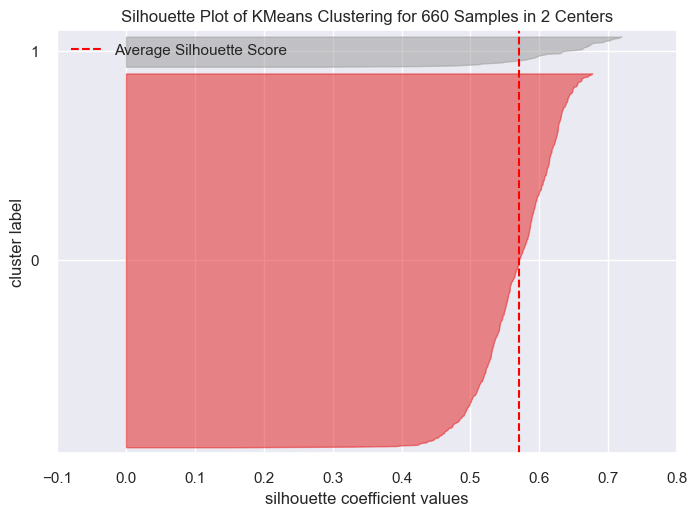

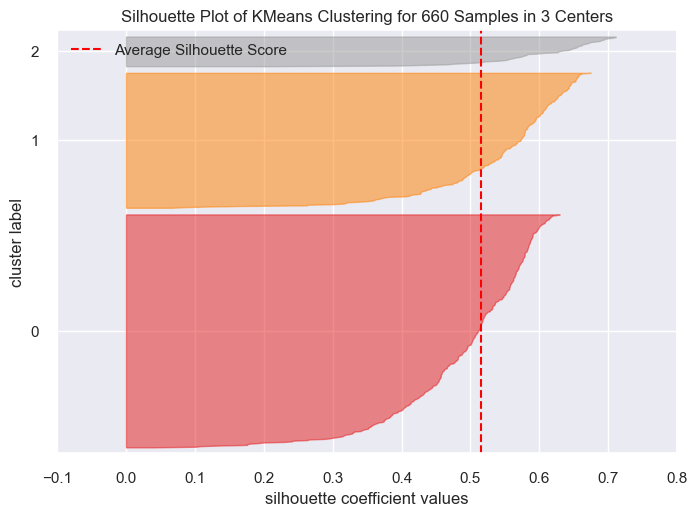

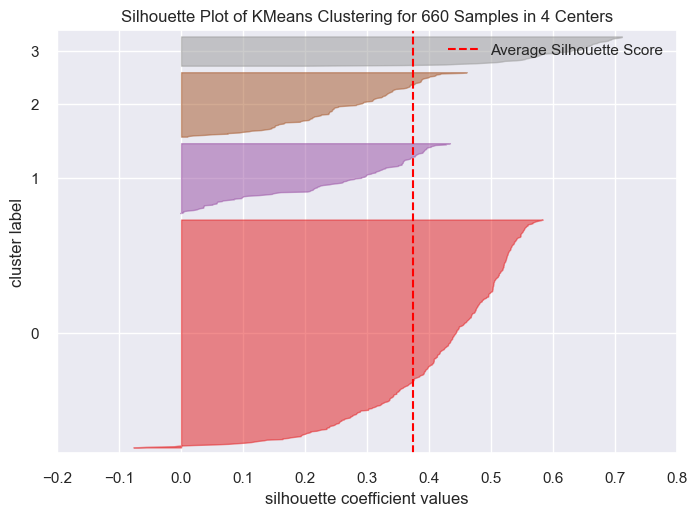

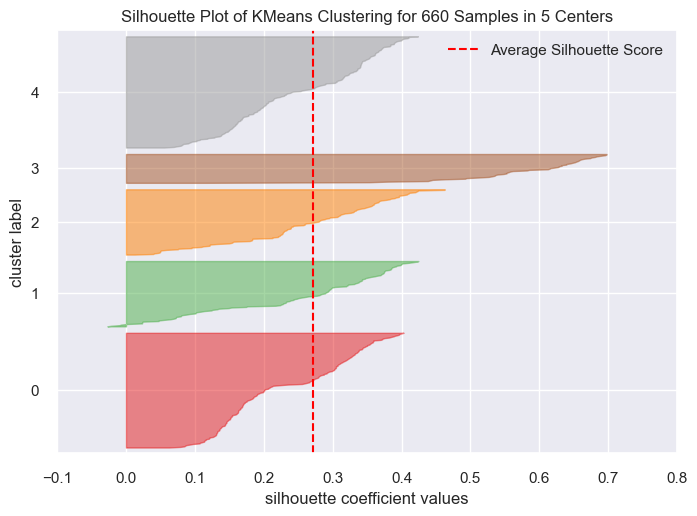

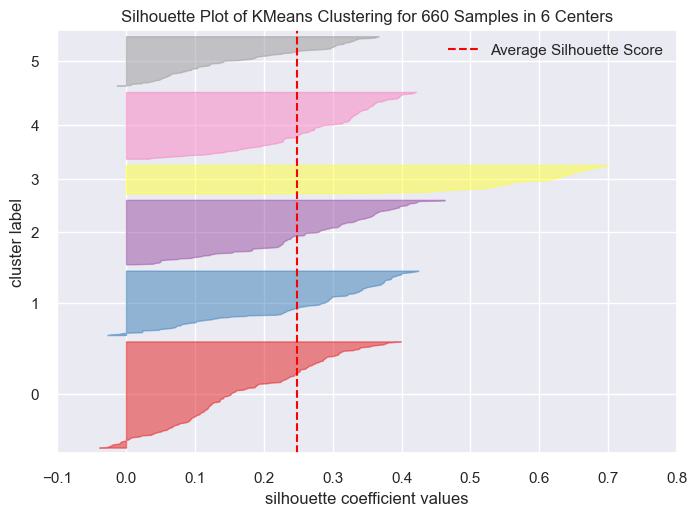

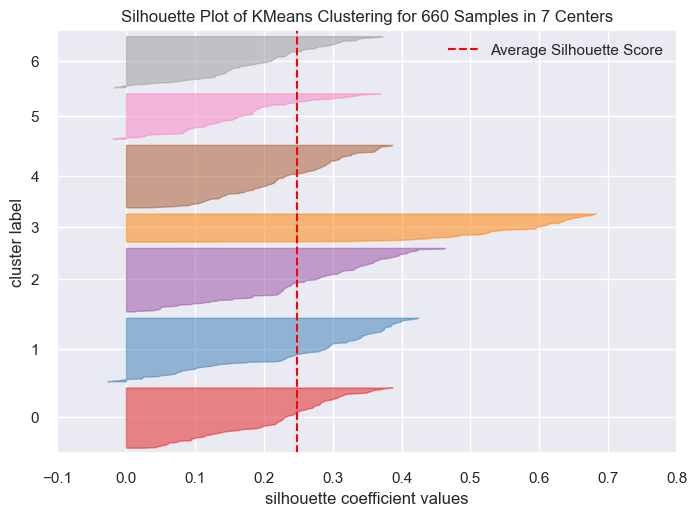

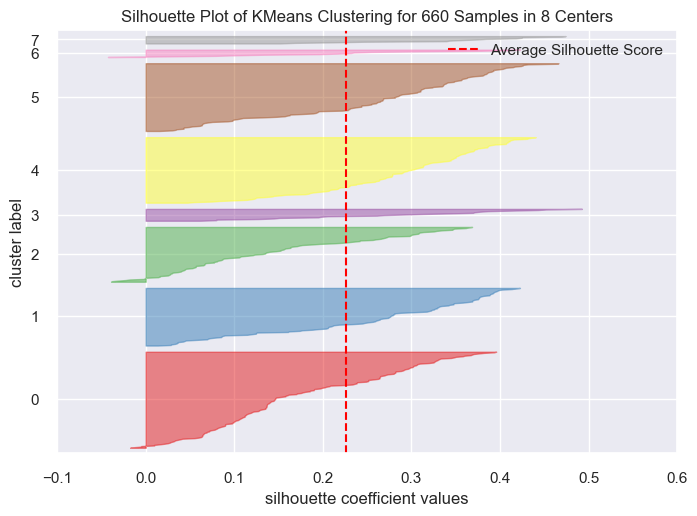

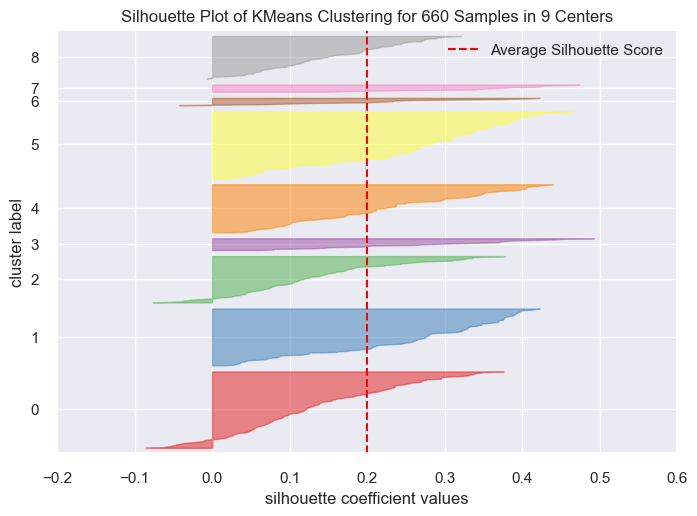

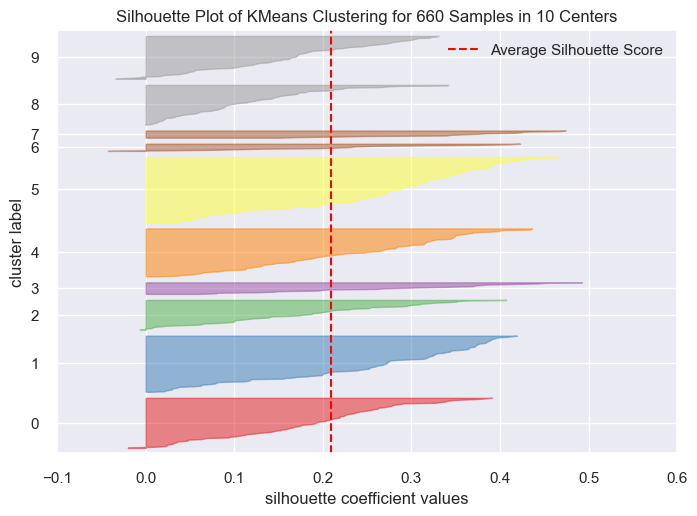

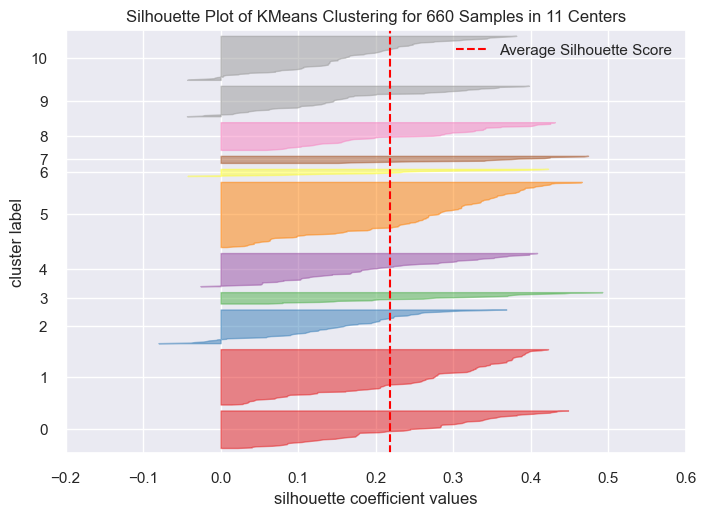

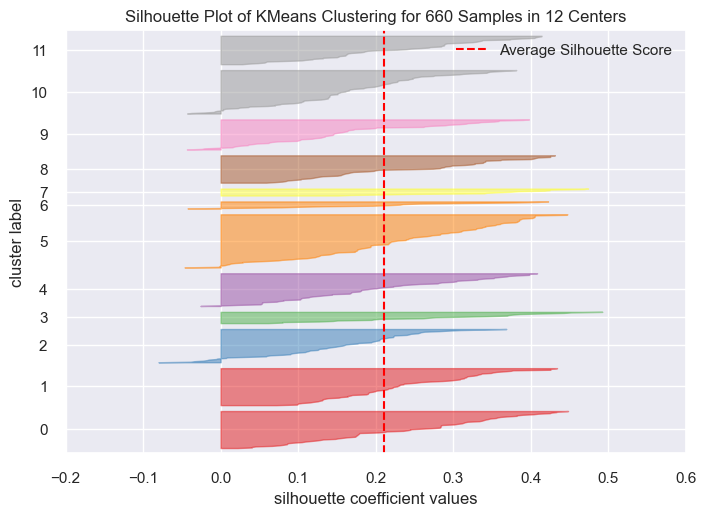

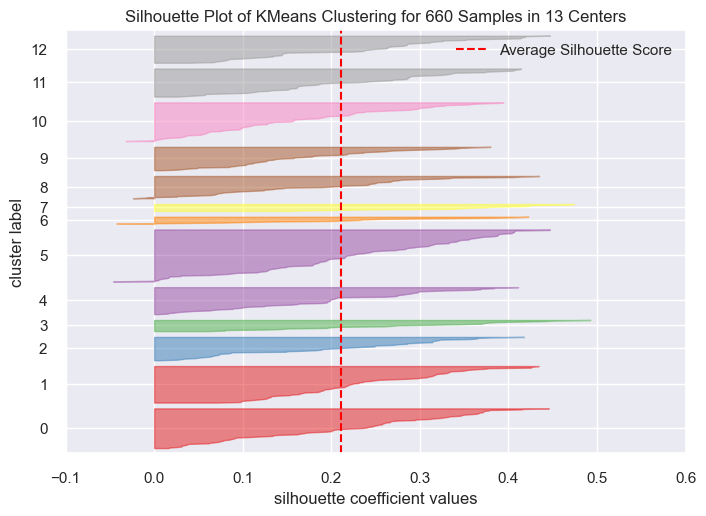

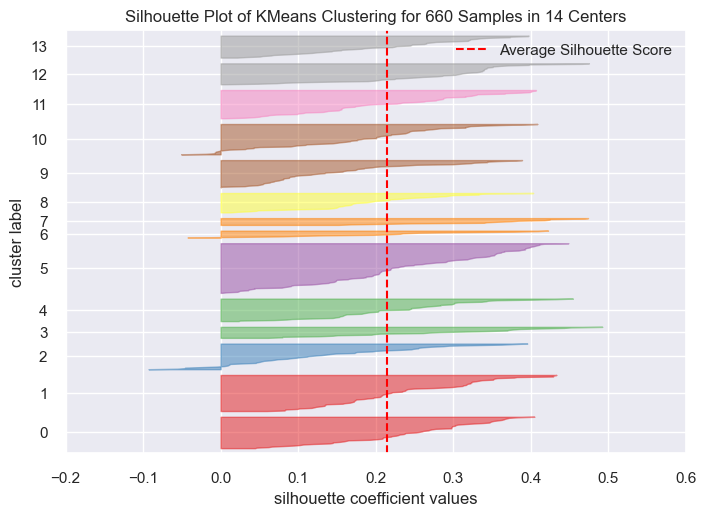

In [106]:
# finding optimal no. of clusters with silhouette coefficients
for i in range(2, 15):
    visualizer = SilhouetteVisualizer(KMeans(i, random_state=1))
    visualizer.fit(k_means_df)
    visualizer.show()

### Creating Final Model

In [108]:
# final K-means model
kmeans = KMeans(n_clusters=3, random_state=1)
km_preds = kmeans.fit_predict((k_means_df))
km_score = silhouette_score(k_means_df, km_preds)

kmeans.fit(k_means_df)

KMeans(n_clusters=3, random_state=1)

In [109]:
# creating a copy of the original data
df1 = df.copy()

# adding kmeans cluster labels to the original and scaled dataframes
k_means_df["KM_segments"] = kmeans.labels_
df1["KM_segments"] = kmeans.labels_
df1.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KM_segments
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,2


### Cluster Profiling

In [111]:
numeric_df1 = df1.select_dtypes(include='number')

km_cluster_profile = numeric_df1.groupby("KM_segments").mean()

km_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KM_segments,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000
1,12174.107143,2.410714,0.933036,3.553571,6.870536
2,141040.000000,8.740000,0.600000,10.900000,1.080000


In [112]:
km_cluster_profile["count_in_each_segment"] = (
    numeric_df1.groupby("KM_segments")["Avg_Credit_Limit"].count().values
)
km_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
KM_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [113]:
km_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
KM_segments,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


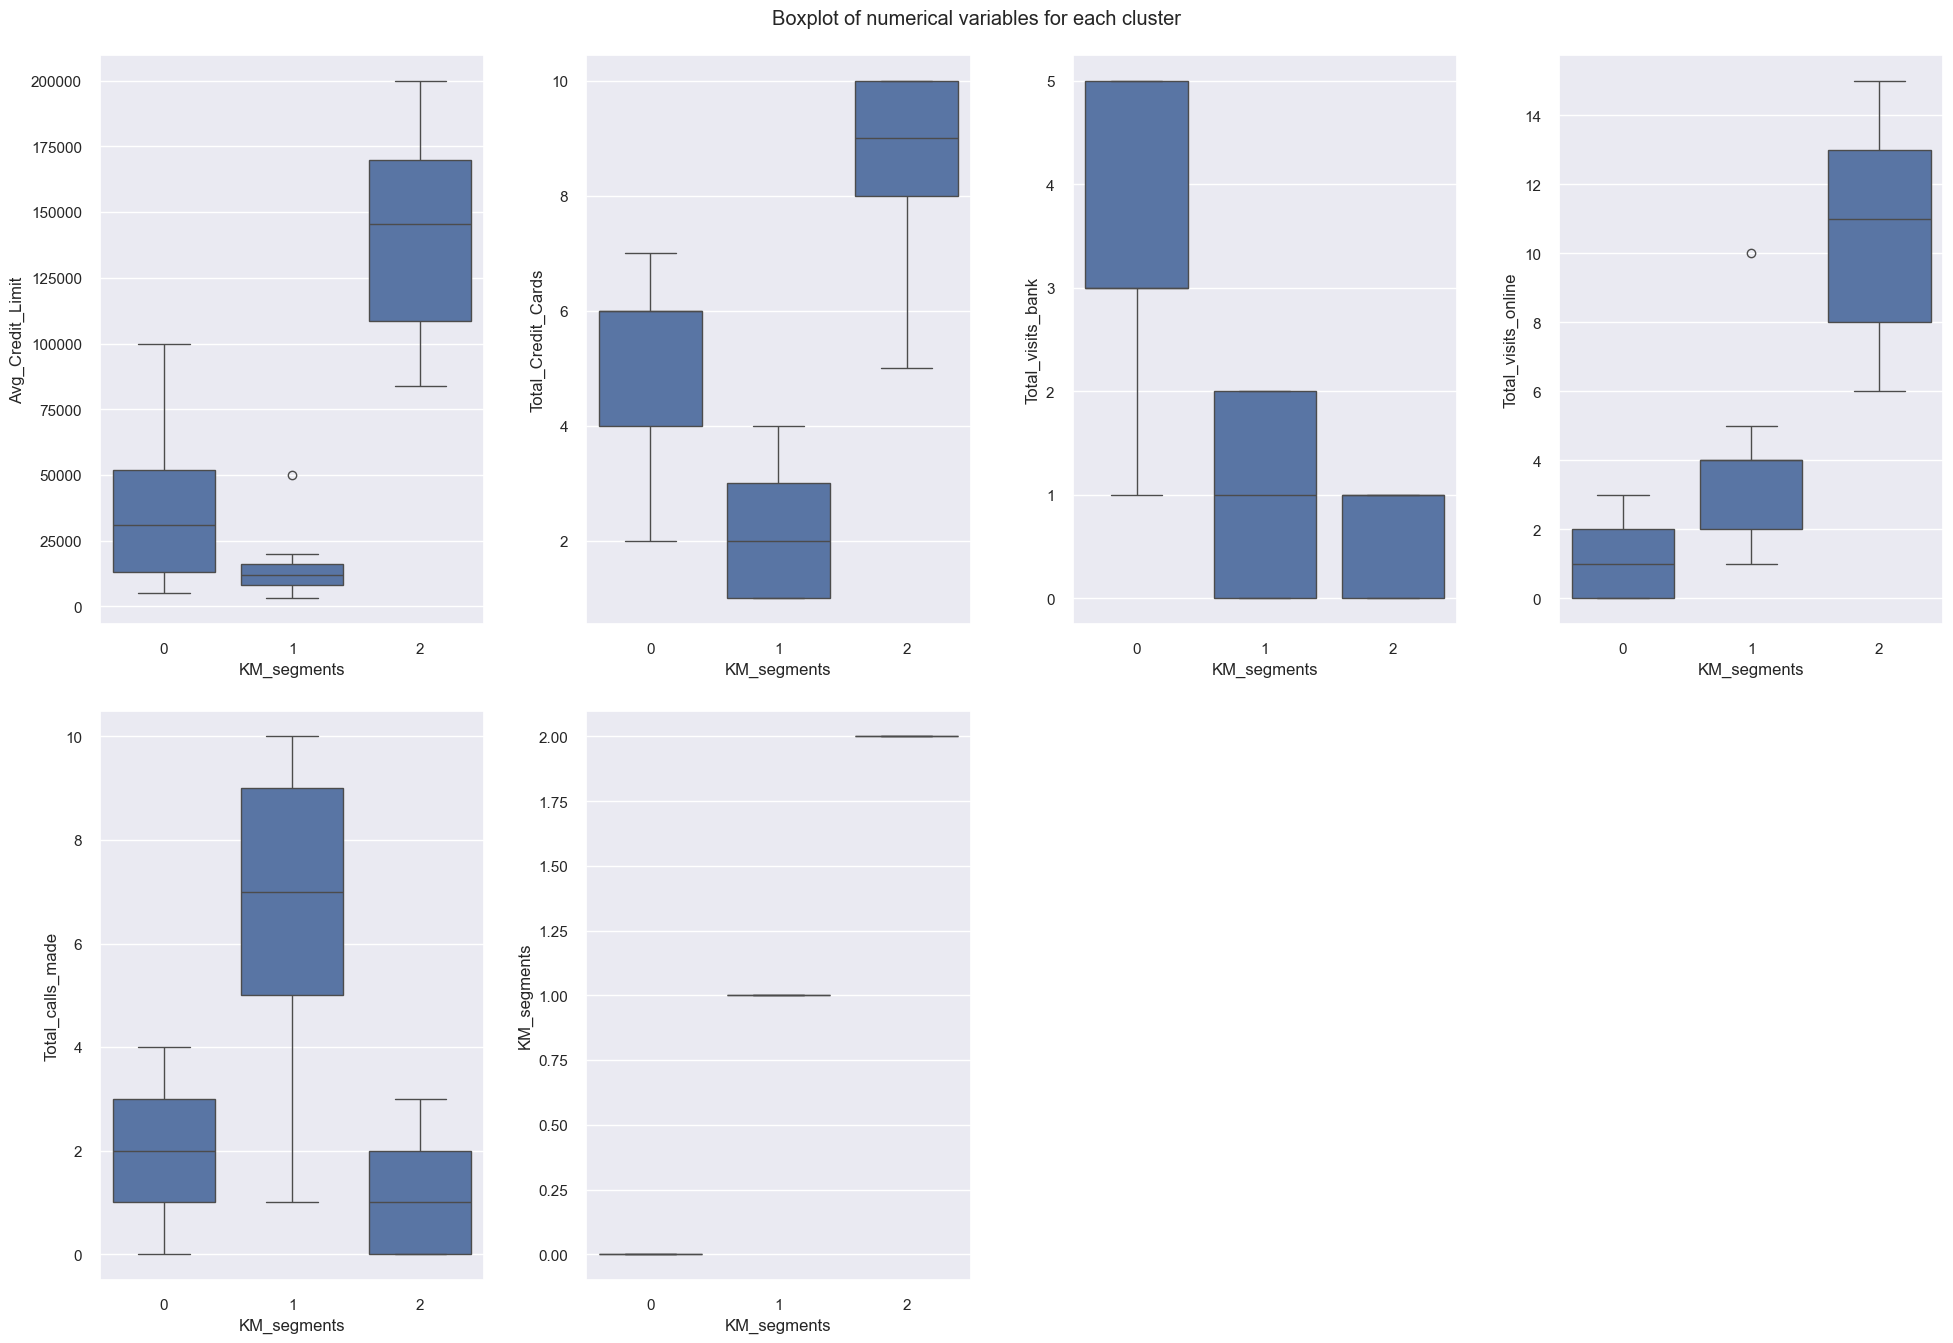

In [114]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")

# selecting numerical columns
num_col = df1.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df1, x="KM_segments", y=variable)

plt.tight_layout(pad=2.0)

## Hierarchical Clustering

### Computing Cophenetic Correlation

In [117]:
hc_df = df_z.copy()

In [118]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.5422791209801747.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042134.
Cophenetic co

**Let's explore different linkage methods with Euclidean distance only.**

In [120]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print('*'*100)
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.
****************************************************************************************************
Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


**Let's view the dendrograms for the different linkage methods with Euclidean distance.**

### Checking Dendrograms

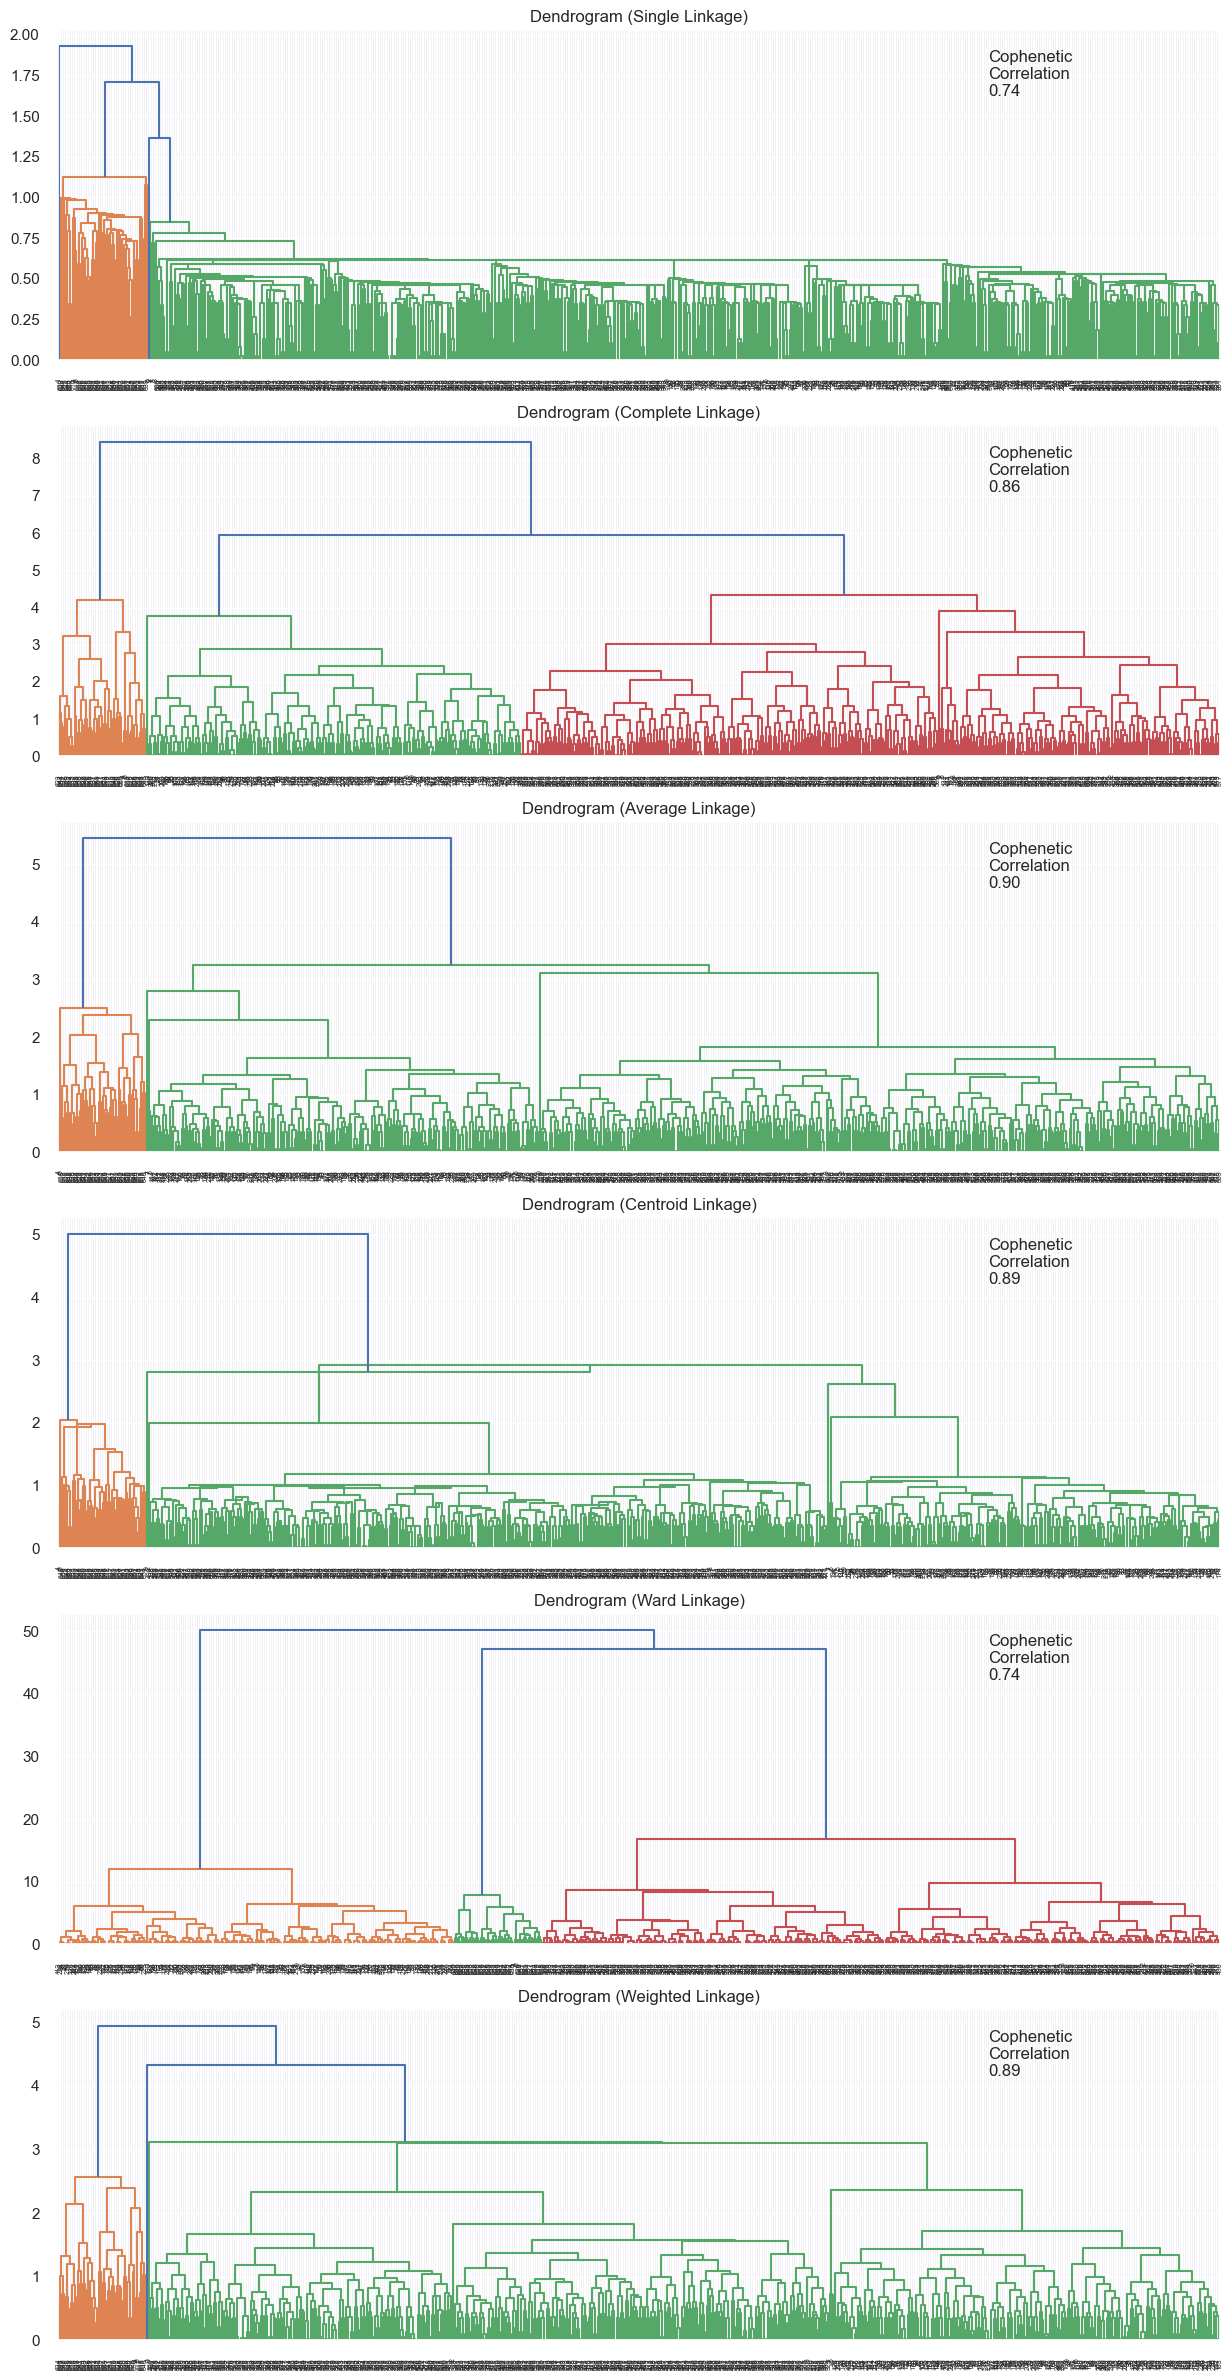

In [123]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

    compare.append([method, coph_corr])

In [124]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

# There is likely a noticeable gap between the merges forming 3 clusters and the merges forming 2 clusters.
# Selecting 3 clusters aligns with the natural structure in the data while keeping the clusters meaningful.

,Linkage,Cophenetic Coefficient
0,single,0.739122
4,ward,0.741516
1,complete,0.859973
5,weighted,0.886175
3,centroid,0.893939
2,average,0.897708


### Creating model using sklearn

In [126]:
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import pairwise_distances
HCmodel = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="average")

hc_preds = HCmodel.fit_predict((hc_df))
hc_score = silhouette_score(hc_df, hc_preds)

HCmodel.fit(hc_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [127]:
# creating a copy of the original data
df2 = df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_segments"] = HCmodel.labels_
df2["HC_segments"] = HCmodel.labels_
df2.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_segments
0,100000,2,1,1,0,0
1,50000,3,0,10,9,2
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,1


### Cluster Profiling

In [129]:
numeric_df2 = df2.select_dtypes(include=['number'])

hc_cluster_profile = numeric_df2.groupby("HC_segments").mean()

hc_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
HC_segments,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168
1,141040.000000,8.740000,0.600000,10.900000,1.080000
2,12197.309417,2.403587,0.928251,3.560538,6.883408


In [130]:
hc_cluster_profile["count_in_each_segment"] = (
    numeric_df2.groupby("HC_segments")["Avg_Credit_Limit"].count().values
)
hc_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


In [131]:
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_segments,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


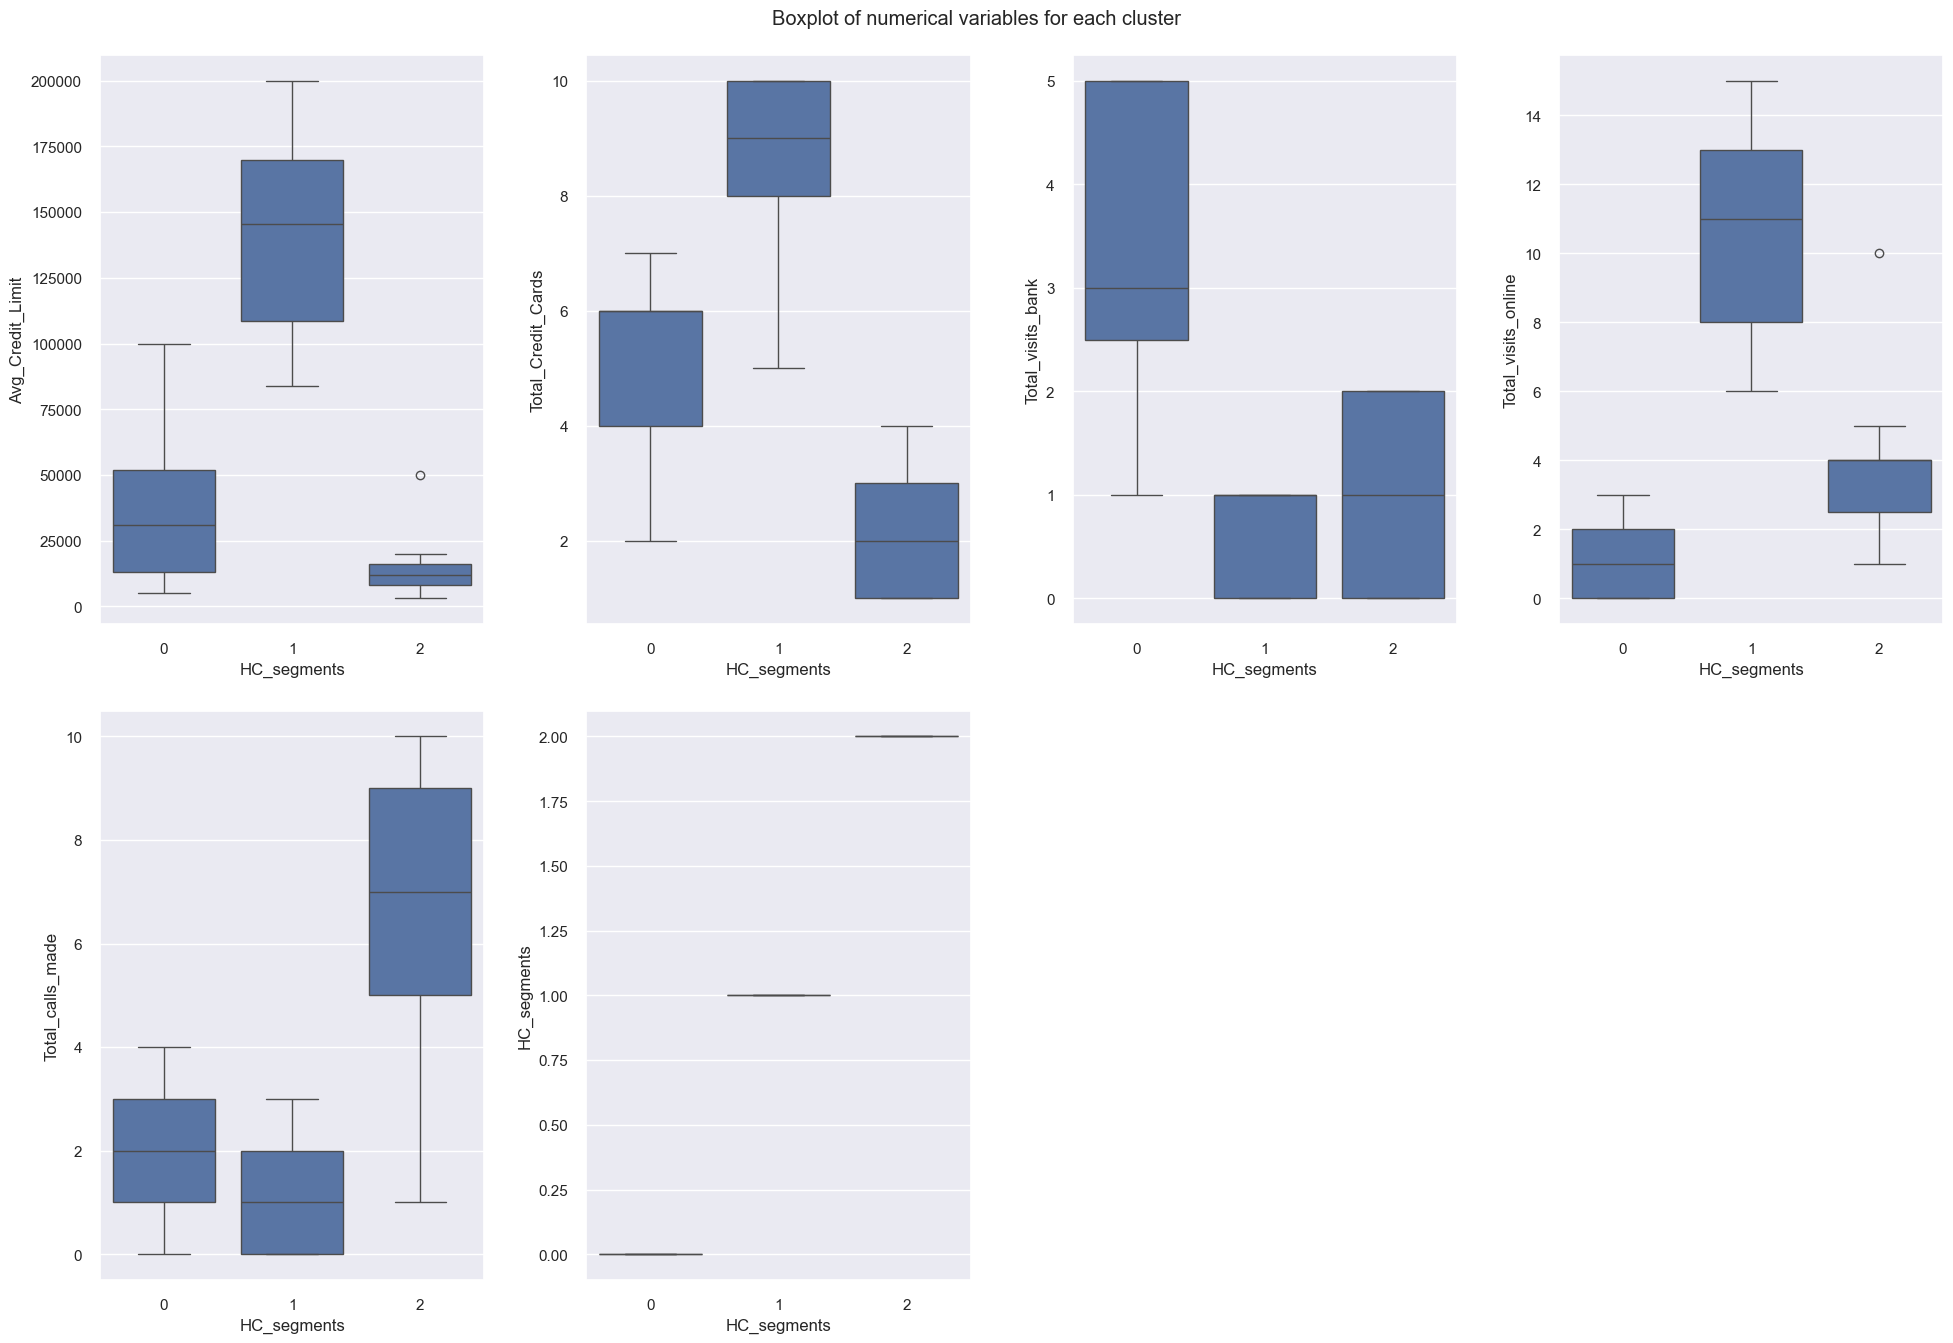

In [132]:
plt.figure(figsize=(20, 20))
plt.suptitle("Boxplot of numerical variables for each cluster")

# selecting numerical columns
num_col = df2.select_dtypes(include=np.number).columns.tolist()

for i, variable in enumerate(num_col):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df2, x="HC_segments", y=variable)

plt.tight_layout(pad=2.0)

## K-means vs Hierarchical Clustering

- Which clustering technique took less time for execution? - Same time.
- Which clustering technique gave you more distinct clusters, or are they the same? - Similar clusters
- How many observations are there in the similar clusters of both algorithms? - Similar Observations
- How many clusters are obtained as the appropriate number of clusters from both algorithms? - For both cases, 3

In [135]:
print('Silhouette Score - Hierarchical Clustering:',hc_score)
print('Silhouette Score - K-means Clustering:',km_score)

# similar Silhoutte scores. Both are almost similar. Customer Profiling is also similar.

Silhouette Score - Hierarchical Clustering: 0.515922432650965
Silhouette Score - K-means Clustering: 0.5157182558881063


## Actionable Insights and Recommendations

- Please refer Business Report

___